In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

In [2]:
def read_minibatch_trainhistory(file_names, nbatches_artifical=1, start_words='Epoch'):
    train_loss = []
    train_epoch = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            for row in f:
                if row.startswith(start_words):
                    epoch = int(row.split()[1])-1
                    batch = int(row.split()[3])
                    loss = float(row.split()[-1])
                    train_epoch.append(epoch+batch/float(nbatches_artifical))
                    train_loss.append(loss)

    return train_epoch, train_loss

In [3]:
def read_epoch_log(file_names, start_words='DONE SYNCING - NOW LOGGING'):
    train_time = []
    valid_time = []
    postproces_time = []
    train_loss = []
    valid_loss = []
    epochs = []

    # Iterate over all log files
    for file_name in file_names:
        with open(file_name, 'r') as f:
            lines = f.readlines()  # Read all lines at once
            i = 0  # Initialize line index
            
            while i < len(lines):
                line = lines[i].strip()
                
                # Look for the start marker for a new logging section
                if line.startswith(start_words):
                    # Initialize variables for this epoch
                    epoch_train_time = None
                    epoch_valid_time = None
                    epoch_postproces_time = None
                    epoch_number = None
                    epoch_train_loss = None
                    epoch_valid_loss = None

                    # Search for subsequent key lines in this section
                    while i < len(lines):
                        i += 1
                        line = lines[i].strip() if i < len(lines) else None
                        
                        if not line:
                            continue
                        
                        # Extract train, valid, and postprocess times
                        if line.startswith("Time for train"):
                            time_parts = line.split()
                            epoch_train_time = float(time_parts[3][:-1])
                            epoch_valid_time = float(time_parts[6][:-1])
                            epoch_postproces_time = float(time_parts[-1][len("postprocessing:"):])
                        
                        # Extract epoch number
                        elif line.startswith("Time taken for epoch"):
                            epoch_number = int(line.split()[4])
                        
                        # Extract train loss and valid loss
                        elif line.startswith("Train loss:"):
                            loss_parts = line.split()
                            try:
                                epoch_train_loss = float(loss_parts[2][:-1])  # Standard train loss format
                            except ValueError:
                                epoch_train_loss = float(loss_parts[2][8:14])  # Adjusted format case
                            epoch_valid_loss = float(loss_parts[-1][:-1])
                            break  # Exit the inner loop after parsing losses
                    
                    # Only append if values were successfully extracted
                    if (epoch_train_time is not None and epoch_valid_time is not None and 
                        epoch_postproces_time is not None and epoch_number is not None and 
                        epoch_train_loss is not None and epoch_valid_loss is not None):
                        train_time.append(epoch_train_time)
                        valid_time.append(epoch_valid_time)
                        postproces_time.append(epoch_postproces_time)
                        epochs.append(epoch_number)
                        train_loss.append(epoch_train_loss)
                        valid_loss.append(epoch_valid_loss)
                
                i += 1  # Move to the next line
                
    return epochs, train_time, valid_time, postproces_time, train_loss, valid_loss

In [4]:
def get_logfiles(dir, end_words='.out'):
    files=[]
    for file in os.listdir(dir):
        if file.endswith(end_words):
            files.append(os.path.join(dir, file))
    return sorted(files)

In [5]:
#log_dirs = ["../test-1608255.out", "../test-1610769.out"]
#nbatches_artifical=2000
cases = ["grad_loss_alpha_0","grad_loss_alpha_0_S"]
# cases = ["SOLPS_auto10_b1_PF","SOLPS_auto10_b1_traj12small"]
output_dir = "../../examples/Dev_BLASNET/basic_config"
output_log={}
for case in cases: 
    output_log[case]={}
    log_dirs = get_logfiles(os.path.join(output_dir, case))
    print(len(log_dirs),log_dirs)
    output_log[case]["logfiles"]=log_dirs
    nbatches_artifical=200
    epochs_minibatch, train_minibatch_loss = read_minibatch_trainhistory(log_dirs, nbatches_artifical=nbatches_artifical) 
    epochs, train_time, valid_time, postproces_time, train_loss, valid_loss = read_epoch_log(log_dirs)
    output_log[case]["epochs_minibatch"] = epochs_minibatch
    output_log[case]["train_minibatch_loss"] = train_minibatch_loss
    output_log[case]["epochs"] = epochs
    output_log[case]["train_time"] = train_time
    output_log[case]["valid_time"] = valid_time
    output_log[case]["postproces_time"] = postproces_time
    output_log[case]["train_loss"] = train_loss
    output_log[case]["valid_loss"] = valid_loss


34 ['../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42644679.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42678790.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42711974.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42715827.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823165.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823166.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823167.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823168.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823169.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823170.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823171.out', '../../examples/Dev_BLASNET/basic_config/grad_loss_alpha_0/matey-42823172.out', '../../examples/Dev_BLASNET/basic_co

In [6]:
def get_record(output_log, case):
    epochs_minibatch = output_log[case]["epochs_minibatch"]
    train_minibatch_loss = output_log[case]["train_minibatch_loss"]
    epochs = output_log[case]["epochs"]  
    train_time = output_log[case]["train_time"] 
    valid_time=output_log[case]["valid_time"] 
    postproces_time=output_log[case]["postproces_time"]
    train_loss = output_log[case]["train_loss"] 
    valid_loss = output_log[case]["valid_loss"]
    return epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss

In [32]:

def moving_average(x, w=5):
    """Compute a simple moving average with window size w."""
    if w < 1:
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_loss(ax, epochs, train_loss, valid_loss, 
              epochs_minibatch=None, train_minibatch_loss=None, 
              case="", ma_window=5):
    """
    Plot training and validation loss with optional moving average smoothing.
    """
    # optional mini-batch losses
    if epochs_minibatch is not None:
        ax.plot(epochs_minibatch, train_minibatch_loss, alpha=0.2, 
                label=case+'-Train minibatch')

    # plot original curves and capture line objects
    line_train, = ax.plot(epochs, train_loss, alpha=0.9, 
                          label=case+'-Train (raw)')
    # line_valid, = ax.plot(epochs, valid_loss, alpha=0.4, 
                        #   label=case+'-Valid (raw)')

    # extract their colors
    train_color = line_train.get_color()
    # valid_color = line_valid.get_color()

    # # plot smoothed curves
    # if ma_window > 1:
    #     ma_epochs = epochs[ma_window-1:]
    #     ma_train = moving_average(train_loss, ma_window)
    #     # ma_valid = moving_average(valid_loss, ma_window)

    #     ax.plot(ma_epochs, ma_train, color=train_color, linewidth=2,
    #             label=case+f'-Train MA{ma_window}')
    #     # ax.plot(ma_epochs, ma_valid, color=valid_color, linewidth=2,
    #             # label=case+f'-Valid MA{ma_window}')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    return ax

In [33]:
def plot_time(ax, epochs, train_time, valid_time, postproces_time, case=""):
    ax.plot(epochs, train_time, label=case+'-Train')
    ax.plot(epochs, valid_time, label=case+'-valid')
    ax.plot(epochs, postproces_time, label=case+'-postp')
    return ax

grad_loss_alpha_0 0.029928578063845634 0.0778246223926544
grad_loss_alpha_0_S 0.02959560789167881 0.0946333482861518


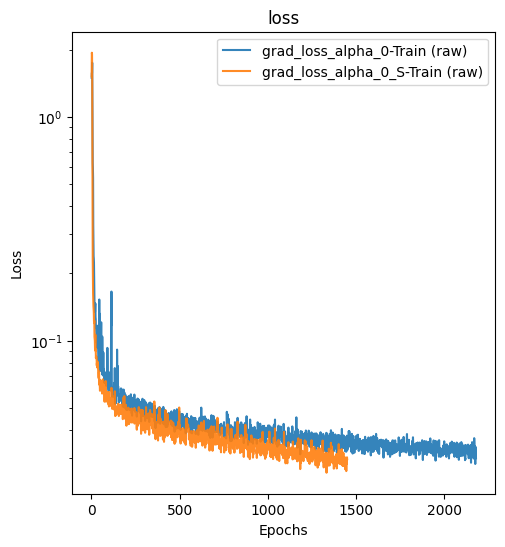

In [34]:
fig = plt.figure(figsize=(12, 6))

ax=fig.add_subplot(1,2,1) 
for case in cases:
    epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    print(case, train_loss[-1], valid_loss[-1])
    ax=plot_loss(ax, epochs, train_loss, valid_loss, case=case, ma_window=20)
ax.legend()
ax.set_title("loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale('log')

# ax=fig.add_subplot(1,2,2) 
# for case in cases:
#     epochs, train_time, valid_time, postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
#     ax=plot_time(ax, epochs, train_time, valid_time, postproces_time, case=case)
# ax.legend()
# ax.set_title("time cost (second)")
# ax.set_xlabel("Epochs")
# ax.set_ylabel("Time")



tiny 0.06161327287554741 0.0694113224744796
big 0.030049849301576614 0.0353169105947017


Text(0, 0.5, 'Time')

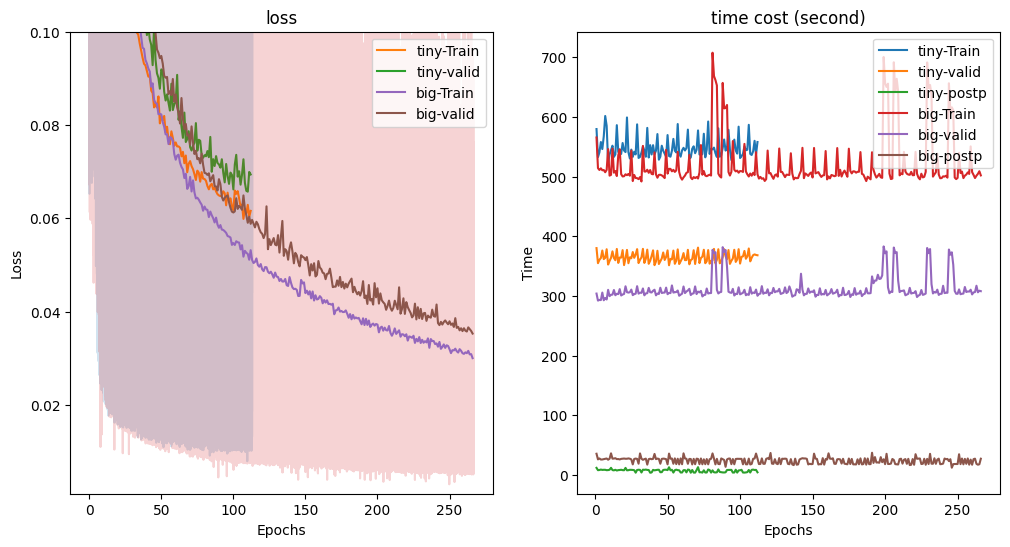

In [19]:
fig = plt.figure(figsize=(12, 6))

ax=fig.add_subplot(1,2,1) 
for case in cases:
    epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    print(case, train_loss[-1], valid_loss[-1])
    ax=plot_loss(ax, epochs, train_loss, valid_loss, epochs_minibatch=epochs_minibatch, train_minibatch_loss=train_minibatch_loss, case=case)
ax.legend()
ax.set_title("loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_yscale('log')
ax.set_ylim(1e-3, 1e-1)

ax=fig.add_subplot(1,2,2) 
for case in cases:
    epochs, train_time, valid_time, postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    ax=plot_time(ax, epochs, train_time, valid_time, postproces_time, case=case)
ax.legend()
ax.set_title("time cost (second)")
ax.set_xlabel("Epochs")
ax.set_ylabel("Time")

